In [55]:
import numpy as np 
import matplotlib.pyplot as plt
import pandas as pd 
import uncertainties as unc
import uncertainties.unumpy as unp
import uncertainties.umath as um
import glob
from scipy.optimize import curve_fit
from lmfit import Model
from scipy.signal import savgol_filter, butter, filtfilt
%matplotlib widget


In [2]:
# load data
path1 = 'data/5-20/long_lock2s.csv'
path2 = 'data/5-20/unlocked2s.csv'
path3 = 'data/5-20/short_lock2s.csv'
path4 = 'data/5-20/xl_lock2s.csv'

long_lock = pd.read_csv(path1, skiprows=7)
no_lock = pd.read_csv(path2, skiprows = 7)
short_lock = pd.read_csv(path3, skiprows = 7)
xl_lock = pd.read_csv(path4, skiprows = 7)

### Develop filtering and differentiation

In [3]:
plt.close('all')

ex_V =  xl_lock[' Input 2 (V)'].to_numpy()
ex_t = xl_lock['% Time (s)'].to_numpy()

sampling_rate = 1/(ex_t[1] - ex_t[0])
noisy_dV_dt = np.gradient(ex_V, ex_t)/500

# Define a low-pass filter
def lowpass_filter(data, cutoff, fs, order=4):
    nyquist = 0.5 * fs  # Nyquist frequency
    normal_cutoff = cutoff / nyquist
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    filtered_data = filtfilt(b, a, data)
    return filtered_data

# Parameters
cutoff_frequency = 150  # Hz (adjust based on your signal)
# Apply the filter to your square wave signal
filtered_signal = lowpass_filter(noisy_dV_dt, cutoff_frequency, sampling_rate)

d2v_dt2 = np.gradient(filtered_signal, ex_t)/200

# Plot the original and filtered signals
plt.plot(ex_t, ex_V, label="Original Signal")
#plt.plot(ex_t, dv_dt, label="Derivative of Signal", linewidth=2)
plt.plot(ex_t, filtered_signal, label="Filtered derivative Signal", linewidth=2)
# plt.plot(ex_t, d2v_dt2, label="Second Derivative of Filtered Signal", linewidth=2)
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
plt.legend()
plt.title("Low-Pass Filtered Square Wave")
plt.grid(True)
plt.axvline(x=0.01746, color='r', linestyle='--', label='pk')
#plt.xlim(0, 0.1)

plt.close('all') # comment out to see plot

### Define Splitter Func which uses above methods

In [4]:
# Define a low-pass filter
def lowpass_filter(data, cutoff, fs, order=4):
    nyquist = 0.5 * fs  # Nyquist frequency is important for digitized signals 
    normal_cutoff = cutoff / nyquist
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    filtered_data = filtfilt(b, a, data)
    return filtered_data

# differentiate triangle wave signal and filter out noise to get squareish wave with nice 0 crossings to split at
# sort split arrays into up and down sweeps
# return up and down sweeps as lists of arrays
def rough_splitter(datalog, padding=False):
    time = datalog['% Time (s)'].to_numpy()
    fp = datalog[' Input 1 (V)'].to_numpy()
    sweep = datalog[' Input 2 (V)'].to_numpy()

    sampling_rate = 1/(time[1] - time[0])
    noisy_dV_dt = np.gradient(sweep, time)/500
    # Parameters
    cutoff_frequency = 150  # Hz good for crossing accuracy without noise

    # Apply the filter to square wave dV/dt of the triangle wave sweep!
    dv_dt = lowpass_filter(noisy_dV_dt, cutoff_frequency, sampling_rate)

    cross_indices = []
    top_indices = []
    bottom_indices = []
    track_slice_index = 0 
    for i in range(len(time)-1):
        top_corner = (dv_dt[i] > 0) and (dv_dt[i+1] < 0)
        bottom_corner = (dv_dt[i] < 0) and (dv_dt[i+1] > 0)
        if top_corner:
            cross_indices.append(i)
            top_indices.append(track_slice_index)
            track_slice_index += 1
        elif bottom_corner:
            cross_indices.append(i+1)
            bottom_indices.append(track_slice_index)
            track_slice_index += 1

    time_arrays = np.split(time, cross_indices)
    fp_arrays = np.split(fp, cross_indices)
    sweep_arrays = np.split(sweep, cross_indices)

    if padding:
        time_arrays = time_arrays[1:-1]
        fp_arrays = fp_arrays[1:-1]
        sweep_arrays = sweep_arrays[1:-1]

    if bottom_indices[-1] > top_indices[-1]:
        bottom_indices = bottom_indices[:-1]
    else:
        top_indices = top_indices[:-1]

    up_time = [time_arrays[i] for i in bottom_indices]
    down_time = [time_arrays[i] for i in top_indices]
    up_fp = [fp_arrays[i] for i in bottom_indices]
    down_fp = [fp_arrays[i] for i in top_indices]
    up_sweep = [sweep_arrays[i] for i in bottom_indices]
    down_sweep = [sweep_arrays[i] for i in top_indices]

    return up_time, up_fp, up_sweep, down_time, down_fp, down_sweep


In [5]:
# process the data
up_time_test, ll_fp_up, ll_sweep_up, down_time_test, ll_fp_down, ll_sweep_down = rough_splitter(long_lock, padding=True)
_, nl_fp_up, nl_sweep_up, _, nl_fp_down, nl_sweep_down = rough_splitter(no_lock, padding=True)
_, sl_fp_up, sl_sweep_up, _, sl_fp_down, sl_sweep_down = rough_splitter(short_lock, padding=True)
_, xl_fp_up, xl_sweep_up, _, xl_fp_down, xl_sweep_down = rough_splitter(xl_lock, padding=True)

#remove one screw up from xl by hand
xl_fp_up = xl_fp_up[1:]
xl_sweep_up = xl_sweep_up[1:]


In [6]:
# Potential Ringdown visualization
plt.close('all')
fig, ax = plt.subplots(1, 2, figsize=(10, 8))
ax[0].set_title('Up Sweeps')
ax[0].set_xlabel('Time (s)')
ax[0].set_ylabel('FP (V)')
ax[0].plot(up_time_test[3][:], ll_fp_up[3][:], color='blue')


ax[1].set_title('Down Sweeps')
ax[1].set_xlabel('Time (s)')
ax[1].set_ylabel('FP (V)')
ax[1].plot(down_time_test[0][:], ll_fp_down[0][:], color='blue')

plt.close('all') # comment out to see plot

In [7]:
# simple data visualization
plt.close('all')
fig, ax = plt.subplots(1, 2, figsize=(10, 8))
ax[0].set_title('Up Sweeps')
ax[0].set_xlabel('Sweep (V)')
ax[0].set_ylabel('FP (V)')
ax[0].plot(ll_sweep_up[3][:], ll_fp_up[3][:], color='blue')


ax[1].set_title('Down Sweeps')
ax[1].set_xlabel('Sweep (V)')
ax[1].set_ylabel('FP (V)')
ax[1].plot(ll_sweep_down[0][:], ll_fp_down[0][:], color='blue')

plt.close('all') # comment out to see plot

In [8]:
plt.close('all')
# visualize the hysteresis
for i in range(len(ll_fp_up)):
    plt.plot(ll_sweep_up[i], ll_fp_up[i], color='red')
    plt.plot(ll_sweep_down[i], ll_fp_down[i], color='blue')
plt.title('F-P piezo hysteresis shown with XY plotting of fp vs sweep voltage')
plt.xlabel('Sweep Voltage (V)')
plt.ylabel('F-P Voltage (V)')

plt.close('all') # comment out to see plot

### Develop Fitting Algorithms

In [9]:
def asym_width(f, gamma0, a, f0):
    return 2*gamma0/(1+np.exp(a*(f-f0)))

def asym_lorentzian(f, A, B, gamma0, a, f0):
    gamma = asym_width(f, *(gamma0, a, f0))/2
    return A*gamma/((f-f0)**2+gamma**2)+B

In [10]:
plt.close('all')
# developing fitting params on a single peak
test_sweep, test_fp = xl_sweep_up[0], xl_fp_up[0]

v_lower, v_upper = -7, -5
lower_bound = np.argmin(np.abs(test_sweep-v_lower))
upper_bound = np.argmin(np.abs(test_sweep-v_upper))

sweep_sample = test_sweep[lower_bound:upper_bound]
fp_sample = test_fp[lower_bound:upper_bound]

test_params = [-0.08, 0, 0, 0, -5.95]


temp_mod = Model(asym_lorentzian)
params = temp_mod.make_params(A=test_params[0], B=test_params[1], gamma0=test_params[2], a=test_params[3], f0=test_params[4])
params['A'].max = 0
params['gamma0'].min = 0



temp_result = temp_mod.fit(fp_sample, params, f=sweep_sample)
plt.scatter(sweep_sample, fp_sample, label = 'data', s=10)
plt.plot(sweep_sample, temp_result.best_fit, label = 'fit')
plt.plot(sweep_sample, temp_result.init_fit, label = 'init fit')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude (V)')
plt.legend()
plt.xlim(-6.45,-5.5)
plt.title('Asym Lorentzian fit robustness test')
print(temp_result.fit_report())

plt.close('all') # comment out to see plot

[[Model]]
    Model(asym_lorentzian)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 638
    # data points      = 1002
    # variables        = 5
    chi-square         = 0.04335770
    reduced chi-square = 4.3488e-05
    Akaike info crit   = -10058.1203
    Bayesian info crit = -10033.5716
    R-squared          = 0.97408379
[[Variables]]
    A:      -0.00809480 +/- 6.4682e-05 (0.80%) (init = -0.08)
    B:       9.2698e-04 +/- 2.2923e-04 (24.73%) (init = 0)
    gamma0:  0.06019581 +/- 6.4066e-04 (1.06%) (init = 0)
    a:      -3.15903478 +/- 0.54738255 (17.33%) (init = 0)
    f0:     -5.93694900 +/- 2.1429e-04 (0.00%) (init = -5.95)
[[Correlations]] (unreported correlations are < 0.100)
    C(A, gamma0) = -0.7608
    C(A, B)      = -0.4156
    C(B, gamma0) = +0.3021


In [11]:
plt.close('all')

# amplitude, asym_strength, asym inverse width, position, ... repeat ... baseline
def fit_func_indiv(s, A1, gamma01, a1, f01, A2, gamma02, a2, f02, B):
    return asym_lorentzian(s, *(A1, B, gamma01, a1, f01)) + asym_lorentzian(s, *(A2, 0, gamma02, a2, f02))

def fit_func_same(s, A1, A2, B, gamma, a, f01, f02):
    return asym_lorentzian(s, *(A1, B, gamma, a, f01)) + asym_lorentzian(s, *(A2, 0, gamma, a, f02))


def fitter(sweep, fp, initial_params, indiv_peaks=False):
    model = Model(fit_func_indiv)
    params = model.make_params(
        A1=initial_params[0],
        gamma01=initial_params[1],
        a1=initial_params[2],
        f01=initial_params[3],
        A2=initial_params[4],
        gamma02=initial_params[5],
        a2=initial_params[6],
        f02=initial_params[7],
        B=initial_params[8]
    )
    params['A1'].max = 0
    params['A2'].max = 0
    params['gamma01'].min = 0
    params['gamma02'].min = 0
    params['f01'].min = np.min(sweep)
    params['f01'].max = np.max(sweep)
    params['f02'].min = params['f01'].value + 1
    params['f02'].max = np.max(sweep)

    if indiv_peaks != True:
        params['gamma01'].expr = 'gamma02'
        params['a1'].expr = 'a2'


    result = model.fit(fp, params, s=sweep)
    return result

def individual_fitter_test(s, fp, init_params, indiv_peaks=False, win = 1):
    result = fitter(s, fp, init_params, indiv_peaks=indiv_peaks)
    print(result.fit_report())
    s_range = np.linspace(np.min(s), np.max(s), 1000)
    fig, ax = plt.subplots(1, 2, figsize=(12, 6))
    for i in range(2):
        ax[i].scatter(s, fp, label = 'data', s=5)
        ax[i].plot(s_range, result.eval(s=s_range), label = 'fit', color = 'orange')
        ax[i].axvline(result.params['f01'].value, color='red', linestyle='--', label = 'fit center 1')
        ax[i].axvline(result.params['f02'].value, color='blue', linestyle='--', label = 'fit center 2')
        ax[i].set_xlabel('Time (s)')
        ax[i].set_ylabel('Amplitude (V)')
        if i == 0:
            ax[i].set_xlim(result.params['f01'].value - win, result.params['f01'].value + win)
        elif i == 1:
            ax[i].set_xlim(result.params['f02'].value - win, result.params['f02'].value + win)

    plt.legend()

test_sweep, test_fp = nl_sweep_down[0], nl_fp_down[0]
#A1, gamma01, a1, f01, A2, gamma02, a2, f02, B
test_params = [-0.1, 1, 1,  -6, -0.1, 1, 1, 2, 0]

individual_fitter_test(test_sweep, test_fp, test_params, indiv_peaks=True, win=0.5)
plt.close('all') # comment out to see plot

[[Model]]
    Model(fit_func_indiv)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 174
    # data points      = 6559
    # variables        = 9
    chi-square         = 0.12212375
    reduced chi-square = 1.8645e-05
    Akaike info crit   = -71418.1277
    Bayesian info crit = -71357.0303
    R-squared          = 0.96162196
[[Variables]]
    A1:      -0.00699526 +/- 4.1965e-05 (0.60%) (init = -0.1)
    gamma01:  0.05763032 +/- 4.6977e-04 (0.82%) (init = 1)
    a1:       16.7131518 +/- 0.65655996 (3.93%) (init = 1)
    f01:     -6.03231103 +/- 1.5754e-04 (0.00%) (init = -6)
    A2:      -0.00806369 +/- 4.6180e-05 (0.57%) (init = -0.1)
    gamma02:  0.06196480 +/- 5.0784e-04 (0.82%) (init = 1)
    a2:       21.0540746 +/- 0.59647901 (2.83%) (init = 1)
    f02:      1.76955937 +/- 1.5101e-04 (0.01%) (init = 2)
    B:        0.00166125 +/- 5.4791e-05 (3.30%) (init = 0)
[[Correlations]] (unreported correlations are < 0.100)
    C(A2, gamma02)  = -0.8064
    C(A

In [12]:
packaged_data_arrays = [[[ll_fp_up, ll_sweep_up], [ll_fp_down, ll_sweep_down]],
                        [[nl_fp_up, nl_sweep_up], [nl_fp_down, nl_sweep_down]],
                        [[sl_fp_up, sl_sweep_up], [sl_fp_down, sl_sweep_down]],
                        [[xl_fp_up, xl_sweep_up], [xl_fp_down, xl_sweep_down]]]
packaged_data_arrays_names = ['long_lock', 'no_lock', 'short_lock', 'xl_lock']
# print(packaged_data_arrays[0][0][0])

In [13]:
plt.close('all')

def fit_all(all_data_arrays, initial_params, same_params=False):
    all_peaks = []
    for i, loglist in enumerate(all_data_arrays):
        up_peaks = []
        down_peaks = []
        both_peaks = [up_peaks, down_peaks]
        for j, updown_list in enumerate(loglist):
            for k in range(len(updown_list[0])):
                temp_fp = updown_list[0][k]
                temp_sweep = updown_list[1][k]
                if same_params:
                    result = fitter(temp_sweep, temp_fp, initial_params, indiv_peaks=False)
                else:
                    result = fitter(temp_sweep, temp_fp, initial_params, indiv_peaks=True)
                peaks = [result.params['f01'].value, result.params['f02'].value]
                if peaks[0] < -7:
                    print(result.fit_report())
                    result.plot_fit()
                    sweep_range = np.linspace(np.min(temp_sweep), np.max(temp_sweep), 1000)
                    plt.plot(sweep_range, result.eval(s=sweep_range), label = 'fit_eval', color = 'orange')
                    plt.axvline(x=peaks[0], color='red', linestyle='--', label = 'fit center 1')
                    plt.axvline(x=peaks[1], color='blue', linestyle='--', label = 'fit center 2')
                    plt.legend()
                    raise ValueError('potentially bad fit')
                    
                both_peaks[j].append(peaks)
        all_peaks.append(both_peaks)

    # print to make sure the data is being processed correctly
    for i, log in enumerate(all_peaks):
        p_up_peaks = log[0]
        p_down_peaks = log[1]
        print(f'{packaged_data_arrays_names[i]} up peaks size: {len(p_up_peaks)}')
        print(f'{packaged_data_arrays_names[i]} down peaks size: {len(p_down_peaks)}')
        print(' ')

    return all_peaks

# redundant params but for clarity 
init_params = [-0.1, 1, 1, -6, -0.1, 1, 1, 2, 0]
packaged_peaks = fit_all(packaged_data_arrays, init_params, same_params=True)


plt.close('all') # comment out to see plot

long_lock up peaks size: 25
long_lock down peaks size: 25
 
no_lock up peaks size: 25
no_lock down peaks size: 26
 
short_lock up peaks size: 16
short_lock down peaks size: 16
 
xl_lock up peaks size: 25
xl_lock down peaks size: 26
 


In [14]:
# logndir example: packaged_peaks[0][0] (long lock, up sweeps)
def peak_num_sorter(log_n_direction):
    first_peaks = [subarray[0] for subarray in log_n_direction]
    second_peaks = [subarray[1] for subarray in log_n_direction]
    return first_peaks, second_peaks

In [15]:
plt.close('all')

def padder(padding, counts, bin_centers, bin_width):
    top_pad = np.arange(1, 1+padding)
    bottom_pad = -1*np.sort(top_pad)[::-1]
    top_pad = top_pad * bin_width + bin_centers[-1]
    bottom_pad = bottom_pad * bin_width + bin_centers[0]
    bin_centers = np.concatenate((bottom_pad, bin_centers, top_pad))
    counts = np.pad(counts, padding, 'constant')
    return counts, bin_centers


def hist_peaks(peak_1s, peak_2s, bins1=40, bins2=40, plot=False, padding=False):
    counts1, bin_edges1 = np.histogram(peak_1s, bins=bins1)
    counts2, bin_edges2 = np.histogram(peak_2s, bins=bins2)
    bin_centers1 = 0.5 * (bin_edges1[1:] + bin_edges1[:-1])
    bin1_width = bin_edges1[1] - bin_edges1[0]
    bin_centers2 = 0.5 * (bin_edges2[1:] + bin_edges2[:-1])
    bin2_width = bin_edges2[1] - bin_edges2[0]
    if padding:
        counts1, bin_centers1 = padder(5, counts1, bin_centers1, bin1_width)
        counts2, bin_centers2 = padder(5, counts2, bin_centers2, bin2_width)
    if plot:
        plt.close('all')
        fig, ax = plt.subplots(1, 2, figsize=(10, 8))
        ax[0].bar(bin_centers1, counts1, width=bin1_width, label='Peak 1', color='blue')
        ax[1].bar(bin_centers2, counts2, width=bin2_width, label='Peak 2', color='red')
        ax[0].set_xlabel('Peak Position (V)')
        ax[0].set_ylabel('Counts')
        fig.suptitle('Peak Position Histogram')

        ax[0].axvline(x=bin_centers1[0])
        ax[0].axvline(x=bin_centers1[-1])
        ax[1].set_xlabel('Peak Position (V)')
        ax[1].set_ylabel('Counts')

        ax[1].axvline(x=bin_centers2[0])
        ax[1].axvline(x=bin_centers2[-1])
        ax[1].legend()
        ax[0].legend()

    return counts1, bin_centers1, counts2, bin_centers2

test_p1s, test_p2s = peak_num_sorter(packaged_peaks[0][0])
hist_peaks(test_p1s, test_p2s, padding=True)

plt.close('all') # comment out to see plot

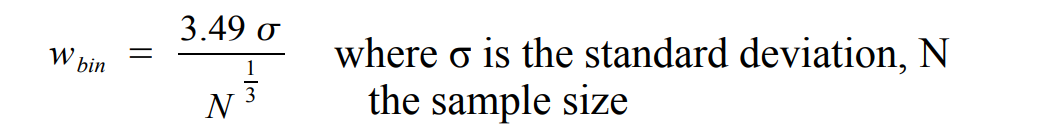

In [50]:
plt.close('all')

def plot_all_hist(all_hists, row_labels=None):
    plt.close('all')
    fig, ax = plt.subplots(4,4, figsize=(10, 8))
    for i, log in enumerate(all_hists):
        print(f'datalog length: {len(log)}')
        for j, direction in enumerate(log):
            print(f'    direction length: {len(direction)}')
            for k, fsr_peak in enumerate(direction):
                counts, bin_cents = fsr_peak[0], fsr_peak[1]
                print(f'        fsr peak length: {len(fsr_peak)}, counts len: {len(counts)}, bin len: {len(bin_cents)}')

                ax[i,2*j+k].bar(bin_cents, counts, width=bin_cents[1]-bin_cents[0], label=f'FSR {k} Peak', color='blue')
                ax[i,2*j+k].set_xlabel('Peak Position (V)')
                ax[i,2*j+k].set_ylabel('Counts')
                ax[i,2*j+k].legend()
    fig.suptitle('Peak Position Histogram')

    # Add col and row labels
    col_labels = ['Up Sweeps', 'Down Sweeps']
    for i, label in enumerate(col_labels):
        fig.text(0.35 + i * 0.45, 0.9, label, va='center', ha='center', fontsize=12)
    for i, label in enumerate(row_labels):
        fig.text(0.05, 0.8 - i * 0.2, label, va='center', ha='center', rotation=90, fontsize=12)

    plt.tight_layout(rect=[0.1, 0, 1, 0.9])  # Leave space for labels

def generate_bin_edges(data):
    min_val = np.min(data)
    max_val = np.max(data)
    samp_N = len(data)
    sigma = np.std(data)
    bin_width = 2.49 * sigma / (samp_N ** (1/3))
    bin_edges = np.arange(min_val-0.5*bin_width, max_val + 0.5*bin_width, bin_width)
    return bin_edges


def hist_all(packaged_peaks, bins1=50, bins2=50, plot_all=False, row_labels=packaged_data_arrays_names, autobins=False):
    all_hists = []
    for i, log in enumerate(packaged_peaks):
        hists = []
        for j,direction in enumerate(log):
            first_peaks, second_peaks = peak_num_sorter(direction)
            if autobins:
                bins1 = generate_bin_edges(first_peaks)
                bins2 = generate_bin_edges(second_peaks)
            counts1, bins1, counts2, bins2 = hist_peaks(first_peaks, second_peaks, bins1=bins1, bins2=bins2, padding=True)
            hists.append([[counts1, bins1],[counts2, bins2]])
        all_hists.append(hists)
    if plot_all:
        plot_all_hist(all_hists, row_labels=row_labels)

    return all_hists

all_hists = hist_all(packaged_peaks, plot_all=True, row_labels=packaged_data_arrays_names, autobins=True)



plt.close('all') # comment out to see plot

datalog length: 2
    direction length: 2
        fsr peak length: 2, counts len: 15, bin len: 15
        fsr peak length: 2, counts len: 15, bin len: 15
    direction length: 2
        fsr peak length: 2, counts len: 15, bin len: 15
        fsr peak length: 2, counts len: 15, bin len: 15
datalog length: 2
    direction length: 2
        fsr peak length: 2, counts len: 15, bin len: 15
        fsr peak length: 2, counts len: 16, bin len: 16
    direction length: 2
        fsr peak length: 2, counts len: 16, bin len: 16
        fsr peak length: 2, counts len: 15, bin len: 15
datalog length: 2
    direction length: 2
        fsr peak length: 2, counts len: 14, bin len: 14
        fsr peak length: 2, counts len: 14, bin len: 14
    direction length: 2
        fsr peak length: 2, counts len: 15, bin len: 15
        fsr peak length: 2, counts len: 14, bin len: 14
datalog length: 2
    direction length: 2
        fsr peak length: 2, counts len: 15, bin len: 15
        fsr peak length: 2, coun

In [65]:
plt.close('all')

def gaussian(x, amplitude, mean, stddev):
    return amplitude * np.exp(-((x - mean) ** 2) / (2 * stddev ** 2))

def fit_hist(x_data, y_data, initial_guess):
    bounds = ([0, -float('inf'), 0], [float('inf'), float('inf'), float('inf')])
    params, covariance = curve_fit(gaussian, x_data, y_data, p0=initial_guess, bounds=bounds)
    return params

def hist_fit(data, plot):
    y_data_test = data[0]
    x_data_test = data[1]
    x_range = np.linspace(x_data_test[0], x_data_test[-1], 1000)
    initial_guess_test = [y_data_test.max(), np.mean(x_data_test), x_data_test[-1]-x_data_test[0]]
    test_params = fit_hist(x_data_test, y_data_test, initial_guess_test)
    init = gaussian(x_range, *initial_guess_test)
    res = gaussian(x_range, *test_params)
    if plot:
        return x_range, init, res, test_params
    else:
        return test_params


# dat_test = all_hists[0][0][0]
# x_data_test = dat_test[1]
# y_data_test = dat_test[0]
# x_range, init, res, test_params = hist_fit(dat_test, plot=True)

# plt.bar(x_data_test, y_data_test, width=x_data_test[1]-x_data_test[0],label='Data')
# plt.plot(x_range, init, label='Initial Guess', color='green')
# plt.plot(x_range, res, label='Fitted Gaussian', color='red')
# plt.xlabel('Peak Position (V)')
# plt.ylabel('Counts')
# plt.legend()

# # plt.close('all') # comment out to see plot

datalog length: 2
    direction length: 2
        fsr peak length: 2
        fsr peak length: 2
    direction length: 2
        fsr peak length: 2
        fsr peak length: 2
datalog length: 2
    direction length: 2
        fsr peak length: 2
        fsr peak length: 2
    direction length: 2
        fsr peak length: 2
        fsr peak length: 2
datalog length: 2
    direction length: 2
        fsr peak length: 2
        fsr peak length: 2
    direction length: 2
        fsr peak length: 2
        fsr peak length: 2
datalog length: 2
    direction length: 2
        fsr peak length: 2
        fsr peak length: 2
    direction length: 2
        fsr peak length: 2
        fsr peak length: 2


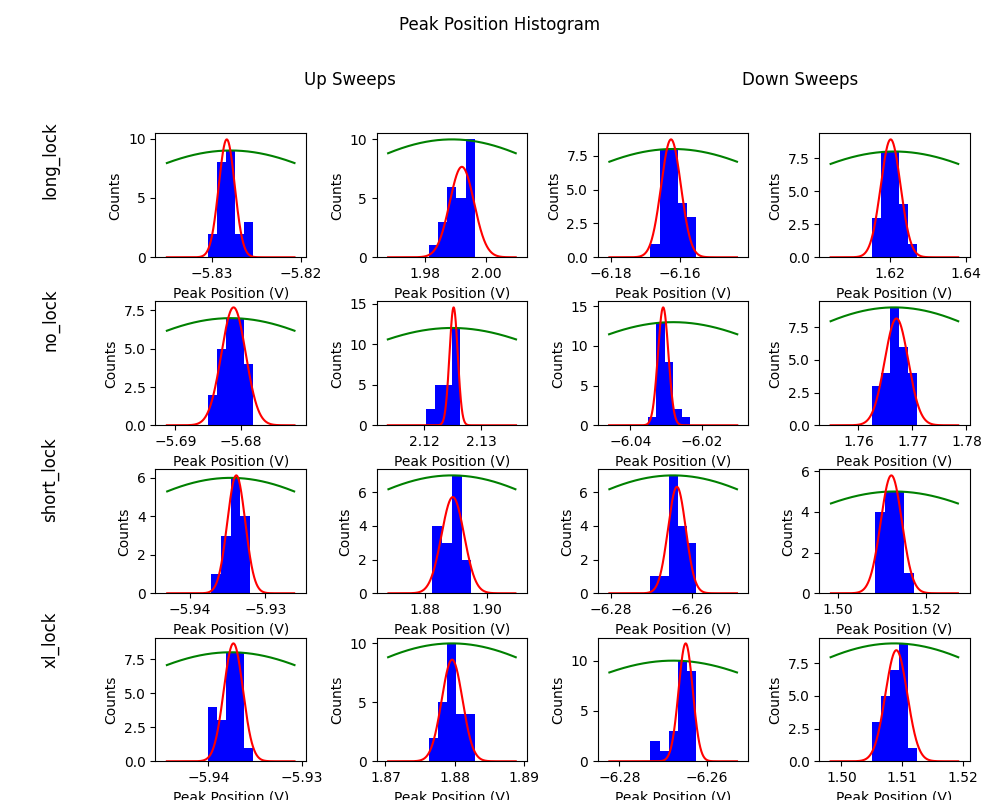

In [66]:
plt.close('all')

def fit_all_hist(all_hists, want_plot=False, row_labels=None):
    if want_plot:
        plt.close('all')
        fig, ax = plt.subplots(4,4, figsize=(10, 8))
        fig.suptitle('Peak Position Histogram')

        # Add col and row labels
        col_labels = ['Up Sweeps', 'Down Sweeps']
        for i, label in enumerate(col_labels):
            fig.text(0.35 + i * 0.45, 0.9, label, va='center', ha='center', fontsize=12)
        for i, label in enumerate(row_labels):
            fig.text(0.05, 0.8 - i * 0.2, label, va='center', ha='center', rotation=90, fontsize=12)

        plt.tight_layout(rect=[0.1, 0, 1, 0.9])  # Leave space for labels

    all_results = []
    for i, log in enumerate(all_hists):
        log_list = []
        print(f'datalog length: {len(log)}')
        for j, direction in enumerate(log):
            print(f'    direction length: {len(direction)}')
            direc = []
            for k, fsr_peak in enumerate(direction):
                print(f'        fsr peak length: {len(fsr_peak)}')
                if want_plot:
                    #print(i,j,k)
                    swp_range, init, res, res_params = hist_fit(fsr_peak, plot=True)
                    counts = fsr_peak[0]
                    bin_cents = fsr_peak[1]
                    ax[i,2*j+k].bar(bin_cents, counts, width=bin_cents[1]-bin_cents[0], label=f'FSR {k} Peak', color='blue')
                    ax[i,2*j+k].plot(swp_range, init, label='Initial Guess', color='green')
                    ax[i,2*j+k].plot(swp_range, res, label='Fitted Gaussian', color='red')
                    ax[i,2*j+k].set_xlabel('Peak Position (V)')
                    ax[i,2*j+k].set_ylabel('Counts')
                    #ax[i,2*j+k].legend()
                    mean = res_params[1]
                    stddev = res_params[2]

                else: 
                    print(f'            fsr counts length: {len(fsr_peak[1])}')
                    print(f'            fsr bin_cents length: {len(fsr_peak[0])}')
                    res_params = hist_fit(fsr_peak, plot=False)
                    mean = res_params[1]
                    stddev = res_params[2]
                    #print(mean, stddev)

                direc.append([mean, stddev])
            log_list.append(direc)
        all_results.append(log_list)
    return all_results

all_results = fit_all_hist(all_hists, want_plot=True, row_labels=packaged_data_arrays_names)

# plt.close('all') # comment out to see plot

In [67]:
print(all_results[0])

[[[-5.8283020595529305, 0.000902555828982927], [1.9921157072721654, 0.003961595924947667]], [[-6.162494331690644, 0.0028711062629435857], [1.6202213189871937, 0.0026165045227823534]]]


In [87]:
FSR = 1.5 #GHz

def transform2f(log_res,log_name):
    print(f'{log_name} Results:')
    dir_dir = ['Upwards sweep', 'Downwards sweep']
    for i, direction in enumerate(log_res):
        print(f'    {dir_dir[i]}')
        print(f'    -------------------------------------------------------------------- ')
        peak1 = unc.ufloat(direction[0][0], direction[0][1])
        peak2 = unc.ufloat(direction[1][0], direction[1][1])
        fsr_v = np.abs(peak2 - peak1)
        conv_fsr = FSR/fsr_v
        peak1_f_unc = direction[0][1] * conv_fsr
        peak2_f_unc = direction[1][1] * conv_fsr
        print(f'    Peak 1: {peak1} V, Peak 2: {peak2} V')
        print(f'    FSR V: {fsr_v} V') #Conv FSR: {conv_fsr} GHz/V')
        print(f'    Peak 1 freq noise: {peak1_f_unc * 1e6} kHz, Peak 2 freq noise: {peak2_f_unc * 1e6} kHz')
        print('     -------------------------------------------------------------------- ')
        print(' ')


In [88]:
for i, log in enumerate(all_results):
    transform2f(log, log_name=packaged_data_arrays_names[i])

long_lock Results:
    Upwards sweep
    -------------------------------------------------------------------- 
    Peak 1: -5.8283+/-0.0009 V, Peak 2: 1.992+/-0.004 V
    FSR V: 7.820+/-0.004 V
    Peak 1 freq noise: 173.12+/-0.09 kHz, Peak 2 freq noise: 759.9+/-0.4 kHz
     -------------------------------------------------------------------- 
 
    Downwards sweep
    -------------------------------------------------------------------- 
    Peak 1: -6.1625+/-0.0029 V, Peak 2: 1.6202+/-0.0026 V
    FSR V: 7.783+/-0.004 V
    Peak 1 freq noise: 553.36+/-0.28 kHz, Peak 2 freq noise: 504.29+/-0.25 kHz
     -------------------------------------------------------------------- 
 
no_lock Results:
    Upwards sweep
    -------------------------------------------------------------------- 
    Peak 1: -5.6811+/-0.0019 V, Peak 2: 2.1252+/-0.0007 V
    FSR V: 7.8063+/-0.0020 V
    Peak 1 freq noise: 358.24+/-0.09 kHz, Peak 2 freq noise: 139.00+/-0.04 kHz
     -------------------------------------

In [90]:
def simple_analyze(packaged_data_arrays):    
    dir_dir = ['Upwards sweep', 'Downwards sweep']
    all_ = []
    for i, log in enumerate(packaged_data_arrays):
        print(f'{packaged_data_arrays_names[i]} Results:')
        hists = []
        for j,direction in enumerate(log):
            print(f'    {dir_dir[j]}')
            print(f'    -------------------------------------------------------------------- ')
            first_peaks, second_peaks = peak_num_sorter(direction)
            first_peak_loc = unc.ufloat(np.mean(first_peaks), np.std(first_peaks))
            second_peak_loc = unc.ufloat(np.mean(second_peaks), np.std(second_peaks))
            fsr_v = np.abs(first_peak_loc - second_peak_loc)
            conv_fsr = FSR/fsr_v
            first_peak_loc_f_unc = first_peak_loc.std_dev * conv_fsr
            second_peak_loc_f_unc = second_peak_loc.std_dev * conv_fsr
            print(f'    Peak 1: {first_peak_loc} V, Peak 2: {second_peak_loc} V')
            print(f'    FSR V: {fsr_v} V')
            print(f'    Peak 1 freq noise: {first_peak_loc_f_unc * 1e6} kHz, Peak 2 freq noise: {second_peak_loc_f_unc * 1e6} kHz')
            print('     -------------------------------------------------------------------- ')
            print(' ')
        
simple_analyze(packaged_peaks)
        


long_lock Results:
    Upwards sweep
    -------------------------------------------------------------------- 
    Peak 1: -5.8279+/-0.0012 V, Peak 2: 1.9914+/-0.0035 V
    FSR V: 7.819+/-0.004 V
    Peak 1 freq noise: 231.14+/-0.11 kHz, Peak 2 freq noise: 667.98+/-0.31 kHz
     -------------------------------------------------------------------- 
 
    Downwards sweep
    -------------------------------------------------------------------- 
    Peak 1: -6.1619+/-0.0031 V, Peak 2: 1.6206+/-0.0028 V
    FSR V: 7.782+/-0.004 V
    Peak 1 freq noise: 597.33+/-0.32 kHz, Peak 2 freq noise: 543.77+/-0.29 kHz
     -------------------------------------------------------------------- 
 
no_lock Results:
    Upwards sweep
    -------------------------------------------------------------------- 
    Peak 1: -5.6811+/-0.0016 V, Peak 2: 2.1246+/-0.0018 V
    FSR V: 7.8058+/-0.0024 V
    Peak 1 freq noise: 313.58+/-0.10 kHz, Peak 2 freq noise: 338.48+/-0.10 kHz
     ---------------------------------